In [1]:
# Models

# Models

In [263]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm
import itertools;
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from itertools import product
from collections import OrderedDict   
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from matplotlib import colors
import seaborn as sns
import time

%matplotlib inline

sns.set_context("poster")

! pip install colour
from colour import Color
red = Color("blue")
colors = list(red.range_to(Color("green"),7))

### Reading and Cleaning Data

In [3]:
### READING DATA

df = pd.read_csv('dataAll_csv8_withmm.csv')
df["slope_class"] = 0
df["slope_class"][df['ref_slope'] < 0] = -1
df["slope_class"][df['ref_slope'] == 0]= 0
df["slope_class"][df['ref_slope'] > 0]= 1
df = df.drop("ref_speed", axis=1)
df.head()



/Users/personalmac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/personalmac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/personalmac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,subject_number,time_0,time_2,time_4,time_6,time_8,time_10,time_12,time_14,time_16,...,feature_L_H_90,feature_L_H_92,feature_L_H_94,feature_L_H_96,feature_L_H_98,feature_L_H_100,subHeight,subWeight,ref_slope,slope_class
0,1,70039.0,70070.0,70114.0,70153.0,70194.0,70214.0,70233.0,70258.0,70284.0,...,4.69,4.69,4.69,4.69,4.69,4.69,168,59,-10,-1
1,1,71249.0,71273.0,71303.0,71333.0,71358.0,71393.0,71418.0,71442.0,71477.0,...,5.59,5.59,5.59,5.59,5.59,5.59,168,59,-10,-1
2,1,72503.0,72527.0,72551.0,72576.0,72600.0,72624.0,72648.0,72672.0,72697.0,...,4.44,4.44,4.44,4.44,4.44,4.44,168,59,-10,-1
3,1,73714.0,73738.0,73762.0,73786.0,73810.0,73834.0,73858.0,73882.0,73906.0,...,3.39,3.39,3.39,3.39,3.39,3.39,168,59,-10,-1
4,1,74913.0,74938.0,74963.0,74988.0,75012.0,75037.0,75062.0,75087.0,75112.0,...,5.10,5.10,5.10,5.10,5.10,5.10,168,59,-10,-1


In [4]:
# Train/Test set split for Leave One Subject Out Cross Validation

subject_test = 6;

df_train = df[df['subject_number'] != subject_test]
df_test = df[df['subject_number'] ==subject_test]

df_train.shape, df_test.shape

((4196, 3251), (810, 3251))

In [23]:
# Cleaning data: 

# y_train (3 classes) : uphill / flat / downhill 
# y_train_multi (7 classes) : -10%/ -5% / 0% / 5% / 10% / 15%/ 20%

X_train = df_train.iloc[:, :-2]
y_train = df_train.iloc[:, -1]
y_train_multi = df_train.iloc[:, -2]

X_test = df_test.iloc[:, :-2]
y_test = df_test.iloc[:, -1]
y_test_multi = df_test.iloc[:, -2]


### Remove unnecessary predictors (Time, Angle Z, Accerelation X and Y)

for i in range(df_train.shape[1]):
    if df_train.columns[i] == 'timeGaitExt_L_0':
        break
        
index_unused_features = i



# IMU Data

a = 52
X_train = df_train[df_train.columns[a:a+107]].copy()
X_test = df_test[df_test.columns[a:a+107]].copy()
a += 107

while a < index_unused_features:
    
    # IMU data except angle Z, acc X, acc Y 

    if not ((df_train.columns[a].split('_')[0] == 'angleZ') or (df_train.columns[a].split('_')[0] == 'accXRot') or (df_train.columns[a].split('_')[0] == 'accYRot')):
        X_train = pd.concat([X_train, df_train[df_train.columns[a:a+107]]], axis =1)
        X_test = pd.concat([X_test, df_test[df_test.columns[a:a+107]]], axis =1)

    a += 107
    
# subject Height, Weight
X_train = pd.concat([X_train, df_train[df_train.columns[-4:-2]]], axis =1)
X_test = pd.concat([X_test, df_test[df_test.columns[-4:-2]]], axis =1)

# subject number
subnum_train = df_train[df_train.columns[0]].values
subnum_test = df_test[df_test.columns[0]].values

print("Number of predictors we have: %d" %X_train.shape[1])

Number of predictors we have: 1928


In [25]:
# standardize data
def standardize(x, x_ref):
    mean = np.mean(x_ref);
    std = np.std(x_ref);  

    x_stand = (x - mean)/std;
    return x_stand

X_train_unstand = X_train.copy();
X_train_std = standardize(X_train, X_train_unstand)

X_test_unstand = X_test.copy();
X_test_std = standardize(X_test, X_train_unstand)

### Custom Functions

In [26]:
def custom_cv(est_list, X, y, paramlist, subject_nums):    
    # iterate through each parameter with estimators premade
    # subject_list is the same order of df entries
    param_score_list = [];
    for e in est_list:
        
        # iterate through each fold
        fold_score_list = [0]*5;
        subject_list = list(set(subject_nums))
        
        for j, sub_num in enumerate(subject_list):
#             sub_num = j + 1 
            valid = subject_nums == sub_num
            train = subject_nums == sub_num
            Xtrain = X[train];
            ytrain = y[train];
            Xvalid = X[valid];
            yvalid = y[valid];
            
            # fit and validate
            e.fit(Xtrain, ytrain)
            fold_score_list[j] = e.score(Xvalid, yvalid)
        
        param_score_list.append(np.mean(fold_score_list))
                    
    i_best = np.argmax(param_score_list)
    
    # fit again on all train data
    best_est = est_list[i_best]
    best_est.fit(X, y)
    
    return paramlist[i_best], param_score_list[i_best], best_est

In [118]:
def subject_set(X, y, subject_num):
    X_list = []
    y_list = []
    
    subject_list = list(set(subject_num))
    
    for j, subject in enumerate(subject_list):

        subject_TF = subject_num == subject

        X_list.append(X[subject_TF]);
        y_list.append(y[subject_TF]);

        
    # split into test and train
    
    X_train_list = [None]*len(subject_list);
    X_test_list = [None]*len(subject_list);

    y_train_list = [None]*len(subject_list);
    y_test_list = [None]*len(subject_list);

    for j in range(0, len(X_list)):
        np.random.seed(9001)
        msk = np.random.rand(len(X_list[j])) < 0.75
        X_train_list[j] = X_list[j][msk]
        X_test_list[j] = X_list[j][~msk]

        y_train_list[j] = y_list[j][msk]
        y_test_list[j] = y_list[j][~msk]
    
    
    return X_train_list, y_train_list, X_test_list, y_test_list

In [119]:
def regression_to_classification(y_true, y_pred):

    y_class = np.zeros(len(y_pred))
    
    for i, prediction in enumerate(y_pred):
        if prediction < -7.5:
            y_class[i] = -10
        elif prediction >= -7.5 and prediction < -2.5:
            y_class[i] = -5
        elif prediction >= -2.5 and prediction < 2.5:
            y_class[i] = 0
        elif prediction >= 2.5 and prediction < 7.5:
            y_class[i] = 5
        elif prediction >= 7.5 and prediction < 12.5:
            y_class[i] = 10
        elif prediction >= 12.5 and prediction < 17.5:
            y_class[i] = 15            
        elif prediction >= 17.5:
            y_class[i] = 20            
        
    y_tf = y_class == y_true
    accuracy = np.sum(y_tf) / len(y_true)  
    
    return y_class, accuracy

In [291]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 1. Classification into 3 Classes (Uphill / Flat / Downhill)

### 1) Baseline Model: Decision Tree (Default: Unlimited Depth)

In [29]:
dt_base = DecisionTreeClassifier(max_depth = None)
dt_base.fit(X_train, y_train)

score_base_train = dt_base.score(X_train, y_train)
score_base_test  = dt_base.score(X_test, y_test)

print('Score on train set is %f' %score_base_train)
print('Score on test set is %f' %score_base_test)

Score on train set is 1.000000
Score on test set is 0.817284


In [33]:
# significant predictors

print('Total Number of Predictors is %d' %np.sum(dt_base.feature_importances_ > 0))

Total Number of Predictors is 78


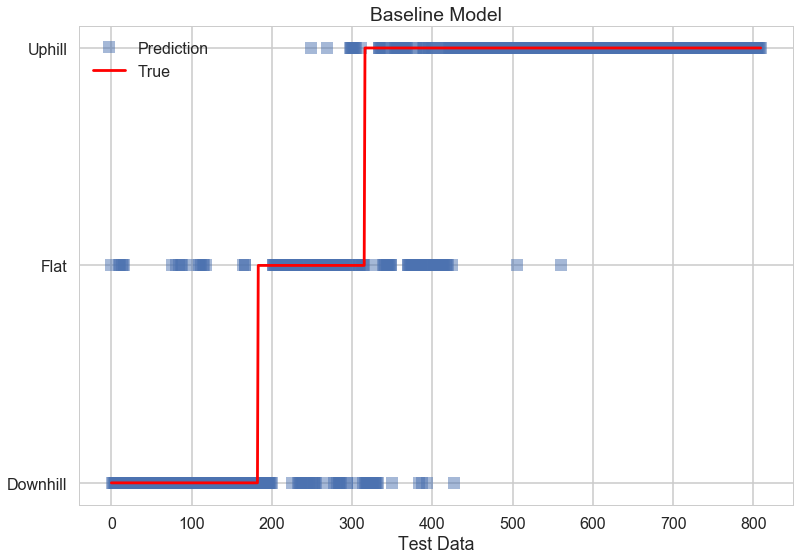

In [264]:
plt.plot(np.arange(len(y_test)), dt_base.predict(X_test), 's', alpha = 0.5, label = 'Prediction')
plt.plot(np.arange(len(y_test)), y_test, 'r-', label = 'True')

plt.yticks( np.unique(y_test), ('Downhill', 'Flat', 'Uphill') )

plt.xlabel("Test Data")
plt.legend()
plt.title("Baseline Model")


### 2) Decision Tree (Leave One Subject Out CV)

In [40]:
paramlist = np.array([2, 4, 8]);
est_list = [];

for p in paramlist:

    dt = DecisionTreeClassifier(max_depth= p)
    est_list.append(dt)
    
best_p, best_score, best_est_dt = custom_cv(est_list, X_train, y_train, paramlist, subnum_train)

print('Best parameter is %f' %best_p)
score_dtcv_train = best_est_dt.score(X_train, y_train)
print('Score on train set is %f' %score_dtcv_train)

score_dtcv_test = best_est_dt.score(X_test, y_test)
print('Score on test set is %f' %score_dtcv_test)

Best parameter is 8.000000
Score on train set is 0.985939
Score on test set is 0.838272


In [46]:
# 10 Most significant predictors

ind_order_dt_cv = np.argsort(best_est_dt.feature_importances_)[::-1]

for j in range(10):
    print(X_test.columns[ind_order_dt_cv[j]])

print('\nTotal Number of Predictors is %d' %np.sum(best_est_dt.feature_importances_> 0))

angleX_L_42
angleY_A_52mm
gyroX_R_64mm
angleX_R_48
angleX_L_62
gyroZ_L_min_mm
angleX_L_max
angleX_R_52
angleY_R_54
accZRot_A_88

Total Number of Predictors is 56


### 3) Decision Tree (Normal CV)

In [48]:
dt = tree.DecisionTreeClassifier ()
tree_depths = {'max_depth': paramlist}
dtGrid  = GridSearchCV(dt, tree_depths, cv = 5)
dtGrid.fit(X_train, y_train)

print(dtGrid.best_params_, 'best score is %f' %dtGrid.best_score_)

dt_cv = tree.DecisionTreeClassifier(max_depth=dtGrid.best_params_['max_depth'])
dt_cv.fit(X_train, y_train)

score_dt_cv_train = dt_cv.score(X_train, y_train)
print('Score on train set for Decision Tree classifier is %f' %score_dt_cv_train)
score_dt_cv_test = dt_cv.score(X_test, y_test)
print('Score on test set for Decision Tree classifier is %f' %score_dt_cv_test)

{'max_depth': 8} best score is 0.745710
Score on train set for Decision Tree classifier is 0.985939
Score on test set for Decision Tree classifier is 0.832099


In [49]:
# 10 Most significant predictors

ind_order_dt_cv_normal = np.argsort(dt_cv.feature_importances_)[::-1]

for j in range(10):
    print(X_test.columns[ind_order_dt_cv_normal[j]])

print('\nTotal Number of Predictors is %d' %np.sum(dt_cv.feature_importances_> 0))

angleX_L_42
angleY_A_52mm
gyroX_R_64mm
angleX_R_48
angleX_L_62
gyroZ_L_min_mm
angleX_L_max
angleX_R_52
angleY_R_54
accZRot_A_88

Total Number of Predictors is 55


### 4) Decision Tree (PCA Components: 90% explained variance)

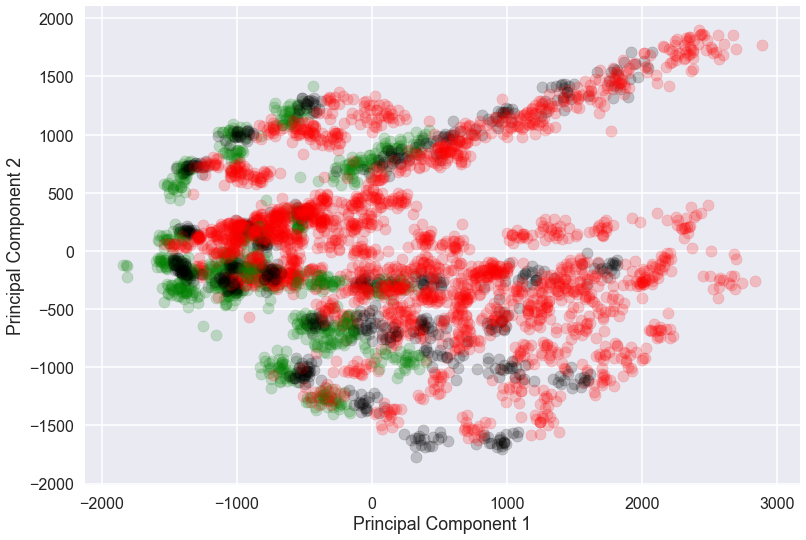

In [55]:
# Try PCA and trees
# visualize in 2 dimensions

ncomp = 2;
pca = PCA(n_components=ncomp)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

for j in range(0, X_train.shape[0]):
    if y_train.values[j] == 1:
        plt.scatter(X_train_pca[j,0], X_train_pca[j, 1], color='red', alpha = 0.2)
    elif y_train.values[j] == -1:
        plt.scatter(X_train_pca[j,0], X_train_pca[j, 1], color='green', alpha = 0.2)
    else:
        plt.scatter(X_train_pca[j,0], X_train_pca[j, 1], color='black', alpha = 0.2)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [60]:
# find number of components to explain 90% of variance

n = 200
pca = PCA(n_components=n)
pca.fit(X_train_std)

for i in range(n):
    if np.sum(pca.explained_variance_ratio_[:i]) > 0.90:
        break

ncomp = i

pca = PCA(n_components=ncomp)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("Number of PCA components: %d" %ncomp)

Number of PCA components: 61


In [68]:
dt_pca = tree.DecisionTreeClassifier(max_depth = 6)
dt_pca.fit(X_train_pca, y_train)

print('Score on train set for Decision Tree classifier(PCA) is %f' %dt_pca.score(X_train_pca, y_train))
print('Score on test set for Decision Tree classifier(PCA) is %f' %dt_pca.score(X_test_pca, y_test))


Score on train set for Decision Tree classifier(PCA) is 0.921354
Score on test set for Decision Tree classifier(PCA) is 0.782716


### 5) Random Forest (Leave One Subject Out CV)

In [171]:
n_list = [8, 16, 32, 64];
est_list = [];
for n in n_list:
    rf = RandomForestClassifier(oob_score = True, n_estimators=n, max_features=int(np.sqrt(len(X_train.columns))) , n_jobs=-1)
    est_list.append(rf)
    

best_p, best_score, best_est_rf = custom_cv(est_list, X_train, y_train, n_list, subnum_train)
best_p, best_score

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

(32, 1.0)

In [172]:
print('Best parameter is: %d' %best_p)

print('Score on train set is %f' %best_est_rf.score(X_train, y_train))

print('Score on test set is %f' %best_est_rf.score(X_test, y_test))

Best parameter is: 32
Score on train set is 1.000000
Score on test set is 0.904938


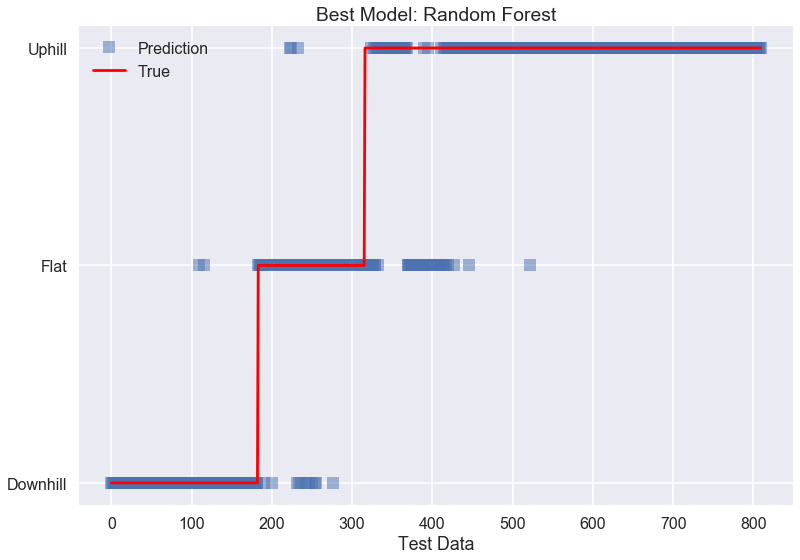

In [199]:
plt.plot(np.arange(len(y_test)), best_est_rf.predict(X_test), 's', alpha = 0.5, label = 'Prediction')
plt.plot(np.arange(len(y_test)), y_test, 'r-', label = 'True')

plt.yticks( np.unique(y_test), ('Downhill', 'Flat', 'Uphill') )

plt.xlabel("Test Data")
plt.legend()
plt.title("Best Model: Random Forest")



Confusion matrix
[[181   2   0]
 [ 11 119   3]
 [  0  61 433]]


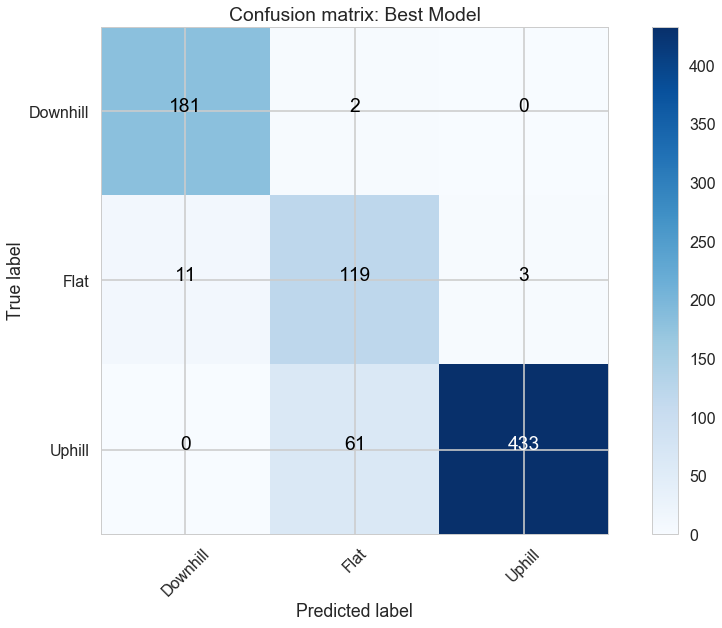

In [296]:
class_names = ['Downhill', 'Flat', 'Uphill']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, best_est_rf.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix: Best Model')

plt.show()

### 6) Adaboost (Leave One Subject Out CV)

In [63]:
tree_depths = [2, 4, 6, 8, 10]; # tree_depths
n_est = [4, 8, 12, 20, 30, 50]
lam = [0.05, 0.1, 0.2, 0.5]
est_list = [];
paramlist = list(itertools.product(tree_depths, n_est, lam))

for td in tree_depths:
    for n in n_est:
        for learn_rate in lam:
            adaboost = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=td), n_estimators= n, learning_rate = learn_rate)
            est_list.append(adaboost)

best_p, best_score, best_est_treeboost = custom_cv(est_list, X_train, y_train, paramlist, subnum_train)

In [64]:
print('Best parameter is', best_p)

print('Score on train set is %f' %best_est_treeboost.score(X_train, y_train))
print('Score on test set is %f' %best_est_treeboost.score(X_test, y_test))

Best parameter is (4, 4, 0.1)
Score on train set is 0.974023
Score on test set is 0.876543


### 7) Logistic Regression (Leave One Subject Out CV)

In [71]:
# Logistic regressioin subject cv
cs = [0.00001, 0.0001, 0.001, 0.01];

est_list = [];

for c in cs:
    clf = LogisticRegression(C=c)
    est_list.append(clf)
    

best_p, best_score, best_clf_cv = custom_cv(est_list, X_train, y_train, cs, subnum_train)



In [72]:
print('Best parameter is')
print(best_p)
score_clf_train = best_clf_cv.score(X_train, y_train)
print('Score on train set is %f' %score_clf_train)

score_clf_test = best_clf_cv.score(X_test, y_test)
print('Score on test set is %f' %score_clf_test)

Best parameter is
0.0001
Score on train set is 0.999285
Score on test set is 0.835802


In [191]:
print("number of predictors:", np.sum(best_clf_cv.coef_[0] != 0))

number of predictors: 1928


### 8) SVM (Leave One Subject Out CV)

In [73]:
## only use significant features
X_train_ld = X_train.iloc[:, ind_order_dt_cv[:20]] #low dimensional
X_test_ld = X_test.iloc[:, ind_order_dt_cv[:20]]

Cs = [ 0.1, 1, 10]
gammas = [0.1, 1, 2]

paramlist = list(itertools.product(Cs, gammas))

est_list = [];

for c in Cs:
    for g in gammas:
        svc = svm.SVC(C=c, kernel = 'rbf', gamma = g)
        est_list.append(svc)
    
best_p, best_score, best_svc_cv = custom_cv(est_list, X_train_ld, y_train, paramlist, subnum_train)



In [74]:
print('Best parameter is')
print(best_p)
score_svc_train = best_svc_cv.score(X_train_ld, y_train)
print('Score on train set is %f' %score_svc_train)

score_svc_test = best_svc_cv.score(X_test_ld, y_test)
print('Score on test set is %f' %score_svc_test)

Best parameter is
(1, 0.1)
Score on train set is 1.000000
Score on test set is 0.609877


### 9) GMM

In [174]:
from sklearn.mixture import GMM

i= 5

X_train_gmm = X_train.iloc[:, ind_order_dt_cv[:i]] #low dimensional
X_test_gmm = X_test.iloc[:, ind_order_dt_cv[:i]]


n_classes = len(np.unique(y_train))

gmm= GMM(n_components= 3, covariance_type='full', init_params='wc', n_iter=20)
gmm.fit(X_train_gmm)
gmm_prediction = gmm.predict(X_test_gmm)

np.sum(gmm_prediction == y_test)/len(y_test+1)

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklea

0.22345679012345679

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


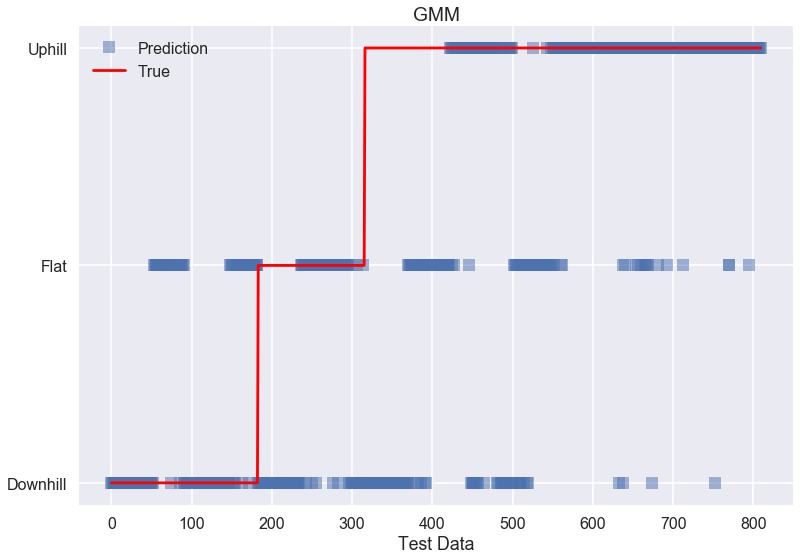

In [201]:
plt.plot(np.arange(len(y_test)), gmm.predict(X_test_gmm), 's', alpha = 0.5, label = 'Prediction')
plt.plot(np.arange(len(y_test)), y_test+1, 'r-', label = 'True')

plt.legend()
np.sum(gmm_prediction == y_test)/len(y_test+1)

plt.xlabel("Test Data")
plt.yticks( np.unique(y_test)+1, ('Downhill', 'Flat', 'Uphill') )

plt.title("GMM")


# 1.1 Classification in 3 classes (Individual Model)

### Random Forest

In [166]:
X_train_list, y_train_list, X_test_list, y_test_list= subject_set(X_train, y_train, subnum_train)

n_list = [2,8, 16, 32, 64]
rf_cv_ind_list = [None] * len(X_train_list)
score_rf_cv_train_list = [None] * len(X_train_list)
score_rf_cv_test_list = [None] * len(X_train_list)

for i in range(len(X_train_list)):

    rf_ind = RandomForestClassifier(oob_score = True, max_features=int(np.sqrt(len(X_train_list[i].columns))) , n_jobs=-1)
    n_est = {'n_estimators': n_list}
    rfGrid_ind  = GridSearchCV(rf_ind, n_est, cv = 5)
    rfGrid_ind.fit(X_train_list[i], y_train_list[i])


    rf_cv_ind = RandomForestClassifier(oob_score = True, n_estimators= rfGrid_ind.best_params_['n_estimators'], 
                                       max_features=int(np.sqrt(len(X_train_list[i].columns))) , n_jobs=-1)
    rf_cv_ind.fit(X_train_list[i], y_train_list[i])
    
    rf_cv_ind_list[i] = rf_cv_ind


    score_rf_cv_train_list[i] = rf_cv_ind.score(X_train_list[i], y_train_list[i])
    score_rf_cv_test_list[i] = rf_cv_ind.score(X_test_list[i], y_test_list[i])


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [167]:
print('Average score on train set is %.3f'  %np.average(score_rf_cv_train_list))
print('Average score on test set is %.3f' %np.average(score_rf_cv_test_list))

print("number of predictor:", X_train_list[0].shape[1])

Average score on train set is 1.000
Average score on test set is 0.999
number of predictor: 1928


In [168]:
i= 1
start_time = time.time()
rf_cv_ind_list[i].predict(X_test_list[i])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.11072587966918945 seconds ---


In [ ]:
plt.plot(np.arange(len(y_test)), gmm.predict(X_test_gmm), 's', alpha = 0.5, label = 'Prediction')
plt.plot(np.arange(len(y_test)), y_test+1, 'r-', label = 'True')

plt.legend()
np.sum(gmm_prediction == y_test)/len(y_test+1)

plt.xlabel("Test Data")
plt.yticks( np.unique(y_test)+1, ('Downhill', 'Flat', 'Uphill') )

plt.title("GMM")



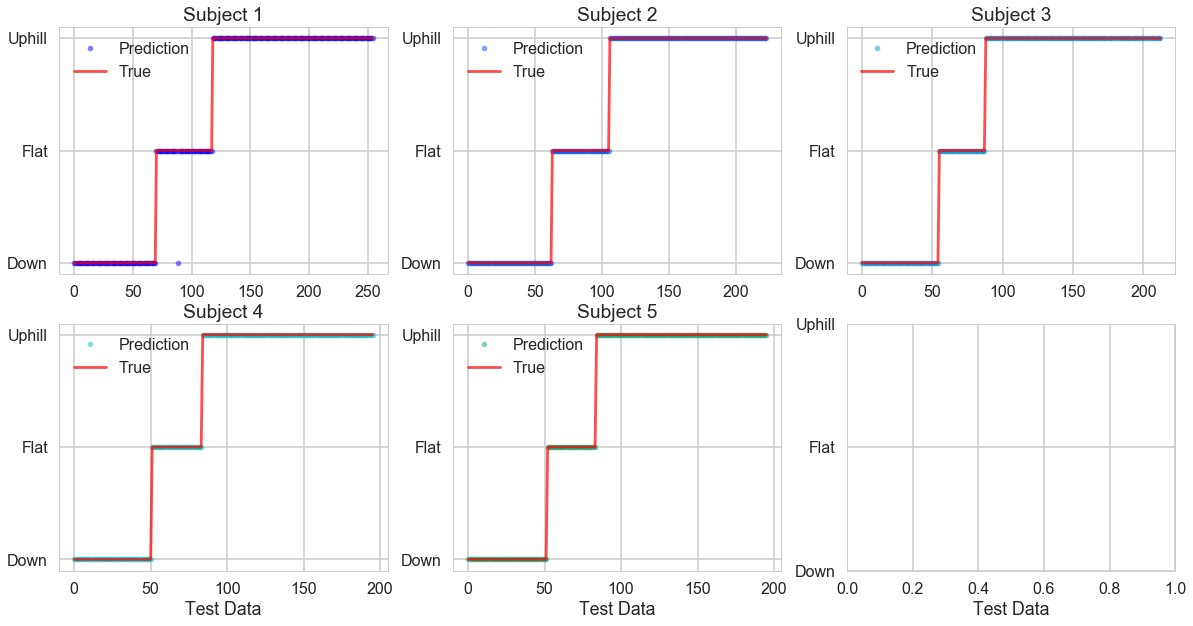

In [280]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
axes = axes.flatten()

for i in range(len(X_train_list)):
    axes[i].plot(rf_cv_ind_list[i].predict(X_test_list[i]), '.', color= colors[i].get_rgb(), alpha = 0.5, label = 'Prediction')
    axes[i].plot(y_test_list[i].values, 'r-', alpha = 0.7, label = 'True')
    axes[i].set_title('Subject '+str(i+1))
    axes[i].legend()
    axes[i].set_yticks( np.unique(y_test))
    axes[i].set_yticklabels(['Down', 'Flat', 'Uphill'])



axes[3].set_xlabel("Test Data")
axes[4].set_xlabel("Test Data")
axes[5].set_xlabel("Test Data")

axes[5].set_yticks( np.unique(y_test))
axes[5].set_yticklabels(['Down', 'Flat', 'Uphill'])


plt.show()

## 2. Classification into 7 classes (-10, -5, 0, 5, 10, 15, 20)

### 1) Baseline Model: Decision Tree (Default: Unlimited Depth)

In [84]:
base_dt_m = DecisionTreeClassifier()
base_dt_m.fit(X_train, y_train_multi)

print('Score on train set is %f' %base_dt_m.score(X_train, y_train_multi))
print('Score on test set is %f' %base_dt_m.score(X_test, y_test_multi))

print('* R2 Score (regression metric) %f' %r2_score(y_test_multi, base_dt_m.predict(X_test)))



Score on train set is 1.000000
Score on test set is 0.472840
* R2 Score (regression metric) 0.722818


In [88]:
print("Number of predictors: %d" %np.sum(base_dt_m.feature_importances_> 0))

Number of predictors: 258


In [87]:
start_time = time.time()
base_dt_m.predict(X_test.iloc[0,:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.004525184631347656 seconds ---


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


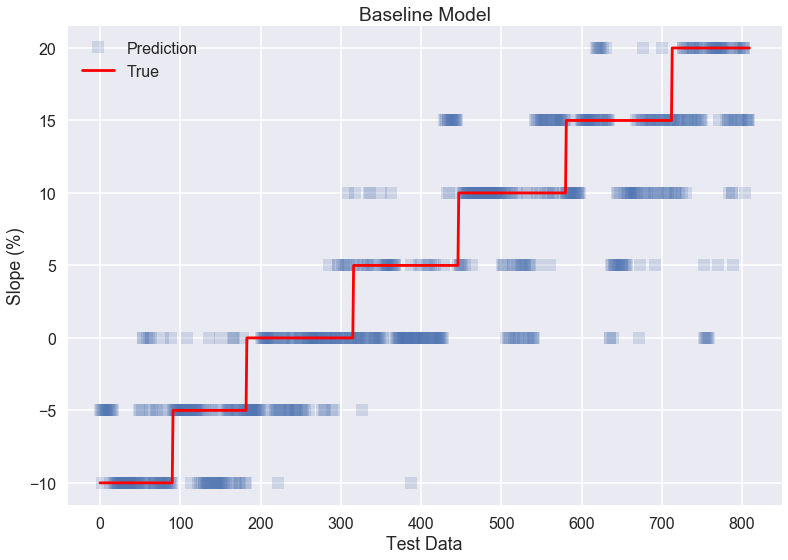

In [212]:
plt.plot(np.arange(len(y_test)), base_dt_m.predict(X_test), 's', alpha = 0.2, label = 'Prediction')
plt.plot(np.arange(len(y_test)), y_test_multi, 'r-', label = 'True')

plt.xlabel("Test Data")
plt.ylabel("Slope (%)")
plt.legend()
plt.title("Baseline Model")

### 2) Decision Tree (Leave One Subject Out CV)

In [93]:
paramlist = np.array([2, 4, 6, 8, 10, 12]);
est_list = [];

for p in paramlist:
#     print(p)
    dt = DecisionTreeClassifier(max_depth= p)
    est_list.append(dt)
    

best_p, best_score, best_est_dt_m = custom_cv(est_list, X_train, y_train_multi, paramlist, subnum_train)

In [91]:
print('Best parameter is %f' %best_p)

print('Score on train set is %f' %best_est_dt_m.score(X_train, y_train_multi))

print('Score on test set is %f' %best_est_dt_m.score(X_test, y_test_multi))


print('* R2 Score (regression metric) %f' %r2_score(y_test_multi, best_est_dt_m.predict(X_test)))

Best parameter is 8.000000
Score on train set is 0.919924
Score on test set is 0.495062
* R2 Score (regression metric) 0.751662


In [92]:
# significant predictors

print('Total Number of Predictors is %d' %np.sum(best_est_dt_m.feature_importances_ > 0))

Total Number of Predictors is 129


### 3) Decision Tree (Normal CV)

In [96]:
paramlist = np.array([4, 6, 8, 10, 12]);

dt = tree.DecisionTreeClassifier ()
tree_depths = {'max_depth': paramlist}
dtGrid_m  = GridSearchCV(dt, tree_depths, cv = 5)
dtGrid_m.fit(X_train, y_train_multi)

print(dtGrid_m.best_params_, 'best score is %f' %dtGrid_m.best_score_)

dt_cv_m = tree.DecisionTreeClassifier(max_depth= dtGrid_m.best_params_['max_depth'])
dt_cv_m.fit(X_train, y_train_multi)

score_dt_cv_train_m = dt_cv_m.score(X_train, y_train_multi)
print('Score on train set for Decision Tree classifier is %f' %score_dt_cv_train_m)
score_dt_cv_test_m = dt_cv_m.score(X_test, y_test_multi)
print('Score on test set for Decision Tree classifier is %f' %score_dt_cv_test_m)

{'max_depth': 10} best score is 0.395615
Score on train set for Decision Tree classifier is 0.968065
Score on test set for Decision Tree classifier is 0.487654


In [97]:
import time
start_time = time.time()
dt_cv_m.predict(X_test.iloc[0,:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.002917051315307617 seconds ---


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [98]:
r2_score_dt_cv_m = r2_score(y_test_multi, dt_cv_m.predict(X_test))
print('* R2 Score (regression metric) %f' %r2_score_dt_cv_m)

print('Total Number of Predictors is %d' %np.sum(dt_cv_m.feature_importances_ > 0))

* R2 Score (regression metric) 0.748145
Total Number of Predictors is 199


### 4) Decision Tree (PCA Components: 90% explained variance)

In [99]:
# find number of components to explain 90% of variance

n = 200
pca = PCA(n_components=n)
pca.fit(X_train_std)
# if np.sum(pca.explained_variance_ratio_) > 0.7:
#     ninetypercent = True;
for i in range(n):
    if np.sum(pca.explained_variance_ratio_[:i]) > 0.90:
        break

ncomp = i


pca = PCA(n_components=ncomp)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

print("number of predictors: %d" %ncomp)

number of predictors: 61


In [101]:
paramlist = np.array([6, 8, 10, 12]);
est_list = [];

for p in paramlist:
    dt_pca = DecisionTreeClassifier(max_depth= p)
    est_list.append(dt_pca)
    

best_p, best_score, best_est_dt_pca_m = custom_cv(est_list, X_train_pca, y_train_multi, paramlist, subnum_train)

In [104]:
print('Best parameter is %f' %best_p)

print('Score on train set is %f' %best_est_dt_pca_m.score(X_train_pca, y_train_multi))

print('Score on test set is %f' %best_est_dt_pca_m.score(X_test_pca, y_test_multi))

r2_score_dt_pca_m = r2_score(y_test_multi, best_est_dt_pca_m.predict(X_test_pca))
print('* R2 Score (regression metric) %f' %r2_score_dt_pca_m)

Best parameter is 12.000000
Score on train set is 0.969018
Score on test set is 0.367901
* R2 Score (regression metric) 0.646136


### 5) Random Forest (Leave One Subject Out CV)

In [205]:
n_list = [2,8, 16, 32, 64, 128];
est_list = [];
for n in n_list:
    rf = RandomForestClassifier(oob_score = True, n_estimators=n, max_features=int(np.sqrt(len(X_train.columns))) , n_jobs=-1)
    est_list.append(rf)
    

best_p, best_score, best_est_rf_m = custom_cv(est_list, X_train, y_train_multi, n_list, subnum_train)
best_p, best_score

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

(16, 1.0)

In [206]:
print('Best parameter is: %d' %best_p)

print('Score on train set is %f' %best_est_rf_m.score(X_train, y_train_multi))

print('Score on test set is %f' %best_est_rf_m.score(X_test, y_test_multi))

print('* R2 Score (regression metric) %f' %r2_score(y_test_multi, best_est_rf_m.predict(X_test)))

Best parameter is: 16
Score on train set is 1.000000
Score on test set is 0.481481
* R2 Score (regression metric) 0.774174


In [207]:
start_time = time.time()
best_est_rf_m.predict(X_test.iloc[0,:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.10733389854431152 seconds ---


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


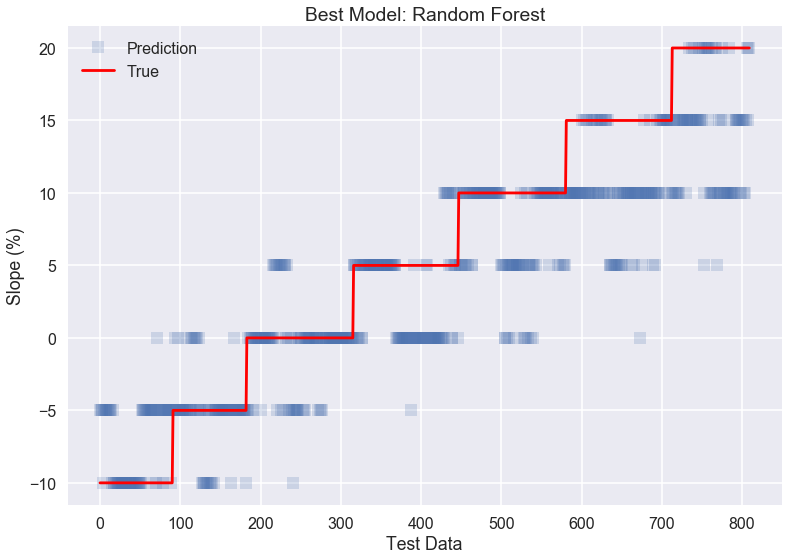

In [211]:
plt.plot(np.arange(len(y_test)), best_est_rf_m.predict(X_test), 's', alpha = 0.2, label = 'Prediction')
plt.plot(np.arange(len(y_test)), y_test_multi, 'r-', label = 'True')

plt.xlabel("Test Data")
plt.ylabel("Slope (%)")
plt.legend()
plt.title("Best Model: Random Forest")

Confusion matrix
[[42 48  1  0  0  0  0]
 [13 68 11  0  0  0  0]
 [ 1 25 94 13  0  0  0]
 [ 0  1 64 56 10  0  0]
 [ 0  0 11 44 79  0  0]
 [ 0  0  1 17 82 32  0]
 [ 0  0  0  2 35 41 19]]


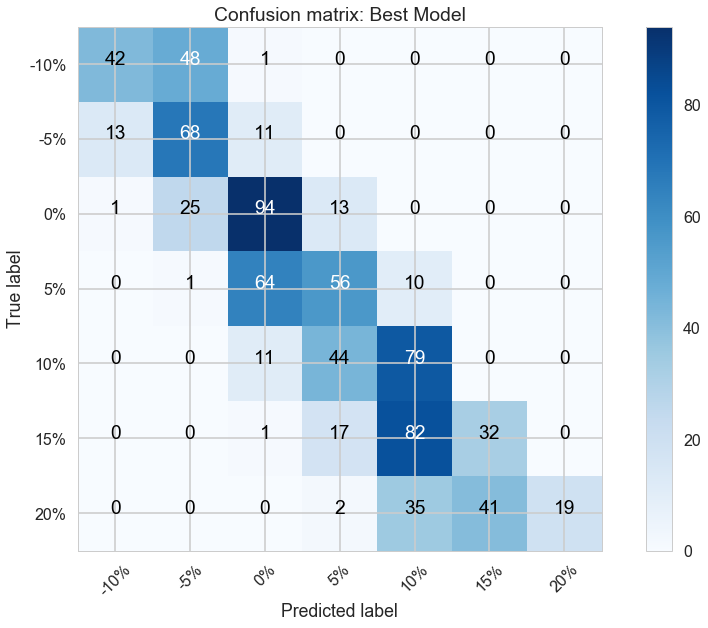

In [297]:
class_names = ['-10%', '-5%', '0%', '5%', '10%', '15%', '20%']

# Compute confusion matrix
cnf_matrix_mt = confusion_matrix(y_test_multi, best_est_rf_m.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_mt, classes=class_names,
                      title='Confusion matrix: Best Model')

plt.show()

### 6) Adaboost(Leave One Subject Out CV)

In [192]:
tree_depths = [ 6, 8, 10, 12]; # tree_depths
n_est = [6, 10, 15, 20]
lam = [0.05, 0.1, 0.2, 0.5]
est_list = [];
paramlist = list(itertools.product(tree_depths, n_est, lam))

for td in tree_depths:
    for n in n_est:
        for learn_rate in lam:
            adaboost = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=td), n_estimators= n, learning_rate = learn_rate)
            est_list.append(adaboost)

best_p, best_score, best_est_treeboost_m = custom_cv(est_list, X_train, y_train_multi, paramlist, subnum_train)

In [193]:
print('Best parameter is:', best_p)

print('Score on train set is %f' %best_est_treeboost_m.score(X_train, y_train_multi))

print('Score on test set is %f' %best_est_treeboost_m.score(X_test, y_test_multi))

print('* R2 Score (regression metric) %f' %r2_score(y_test_multi, best_est_treeboost_m.predict(X_test)))

Best parameter is: (6, 6, 0.1)
Score on train set is 0.946616
Score on test set is 0.490123
* R2 Score (regression metric) 0.769601


In [194]:
start_time = time.time()
best_est_treeboost_m.predict(X_test.iloc[0,:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0042531490325927734 seconds ---


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### 7) Logistic Regression (Leave One Subject Out CV)

In [110]:
Cs = np.array([0.0001, 0.01, 10, 1000])

est_list = [];
for c in Cs:
    clf = LogisticRegression(C = c, multi_class='ovr');
    est_list.append(clf)

best_p, best_score, best_est_log_m = custom_cv(est_list, X_train_std, y_train_multi, Cs, subnum_train)
best_p

10.0

In [111]:

print('Score on train set for Decision Tree classifier is %.3f' %best_est_log_m.score(X_train_std, y_train_multi))

print('Score on test set for Decision Tree classifier is %.3f' %best_est_log_m.score(X_test_std, y_test_multi))

print('* R2 Score (regression metric) %f' %r2_score(y_test_multi, best_est_log_m.predict(X_test_std)))

print("number of predictors: %d" %np.sum(best_est_log_m.coef_[0] >0))

Score on train set for Decision Tree classifier is 1.000
Score on test set for Decision Tree classifier is 0.406
* R2 Score (regression metric) 0.508600
number of predictors: 953


In [112]:
start_time = time.time()
best_est_log_m.predict(X_test_std.iloc[0,:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0010502338409423828 seconds ---


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


# 2.1 Classification into 7 classes (Individual Models)

### Random Forest

In [161]:
X_train_list_n, y_train_multi_list_n, X_test_list_n, y_test_multi_list_n= subject_set(X_train, y_train_multi, subnum_train)

n_list = [2,8, 16, 32, 64]
rf_cv_ind_list_n = [None] * len(X_train_list_n)
score_rf_cv_train_list_n = [None] * len(X_train_list_n)
score_rf_cv_test_list_n = [None] * len(X_train_list_n)

for i in range(len(X_train_list_n)):

    rf_ind_n = RandomForestClassifier(oob_score = True, max_features=int(np.sqrt(len(X_train_list_n[i].columns))) , n_jobs=-1)
    n_est = {'n_estimators': n_list}
    rfGrid_ind_n  = GridSearchCV(rf_ind_n, n_est, cv = 5)
    rfGrid_ind_n.fit(X_train_list_n[i], y_train_multi_list_n[i])


    rf_cv_ind_n = RandomForestClassifier(oob_score = True, n_estimators= rfGrid_ind_n.best_params_['n_estimators'], 
                                       max_features=int(np.sqrt(len(X_train_list_n[i].columns))) , n_jobs=-1)
    rf_cv_ind_n.fit(X_train_list_n[i], y_train_multi_list_n[i])
    
    rf_cv_ind_list_n[i] = rf_cv_ind_n


    score_rf_cv_train_list_n[i] = rf_cv_ind_n.score(X_train_list_n[i], y_train_multi_list_n[i])
    score_rf_cv_test_list_n[i] = rf_cv_ind_n.score(X_test_list_n[i], y_test_multi_list_n[i])


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: 

In [162]:
print('Average score on train set is %.3f'  %np.average(score_rf_cv_train_list_n))
print('Average score on test set is %.3f' %np.average(score_rf_cv_test_list_n))

print("number of predictor:", X_train_list_n[0].shape[1])

Average score on train set is 1.000
Average score on test set is 0.992
number of predictor: 1928


In [163]:
r2_score_rf_ind_list_n = [None]*5
for i in np.arange(len(X_train_list_n)):
    r2_score_rf_ind_list_n[i] = r2_score(y_test_multi_list_n[i], rf_cv_ind_list_n[i].predict(X_test_list_n[i]))

print('* R2 Score (regression metric) %f' %np.average(r2_score_rf_ind_list_n))

* R2 Score (regression metric) 0.997017


In [164]:
i= 1
start_time = time.time()
rf_cv_ind_list_n[i].predict(X_test_list_n[i])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.1100001335144043 seconds ---


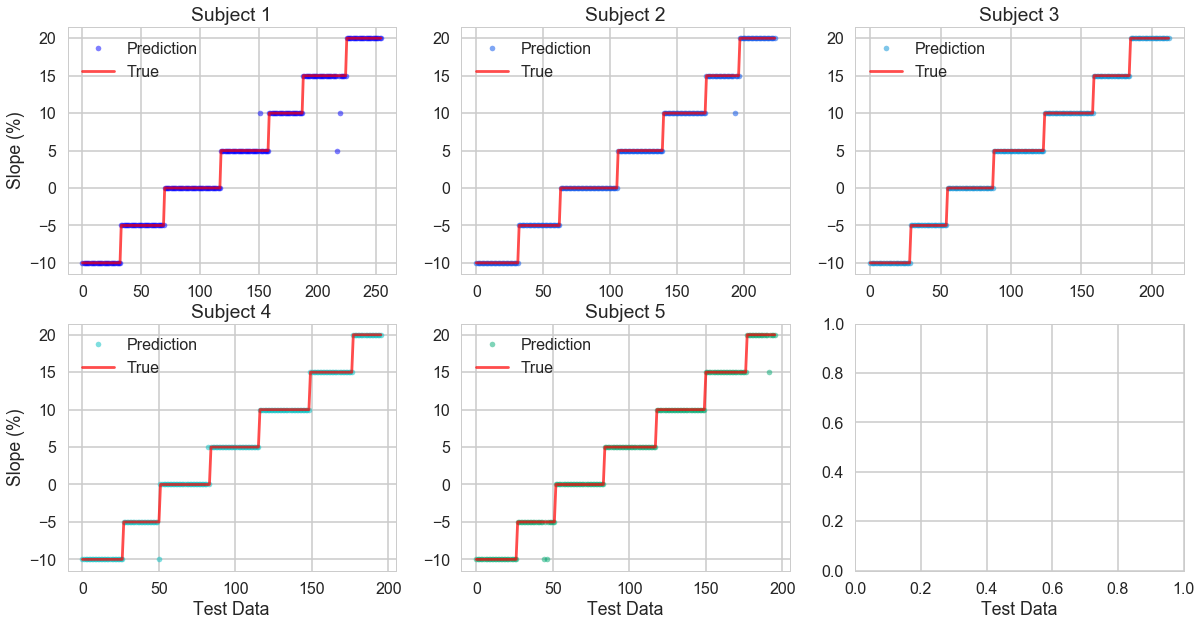

In [266]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
axes = axes.flatten()

for i in range(len(X_train_list_n)):
    axes[i].plot(rf_cv_ind_list_n[i].predict(X_test_list_n[i]), '.', color= colors[i].get_rgb(), alpha = 0.5, label = 'Prediction')
    axes[i].plot(y_test_multi_list_n[i].values, 'r-', alpha = 0.7, label = 'True')
    axes[i].set_title('Subject '+str(i+1))
    axes[i].legend()



axes[3].set_xlabel("Test Data")
axes[4].set_xlabel("Test Data")
axes[5].set_xlabel("Test Data")

axes[0].set_ylabel("Slope (%)")
axes[3].set_ylabel("Slope (%)")


plt.show()

# 3. Regression

### 1) Baseline Model: Linear Regression

In [123]:
linear = LinearRegression()
linear.fit(X_train, y_train_multi)


print('Score on train set is %.3f' %linear.score(X_train, y_train_multi))

print('Score on test set is %.3f' %linear.score(X_test, y_test_multi))

print("Classfication converted accuracy on Test set: %0.3f" %regression_to_classification(y_test_multi, linear.predict(X_test))[1])

Score on train set is 0.991
Score on test set is 0.917
Classfication converted accuracy on Test set: 0.727


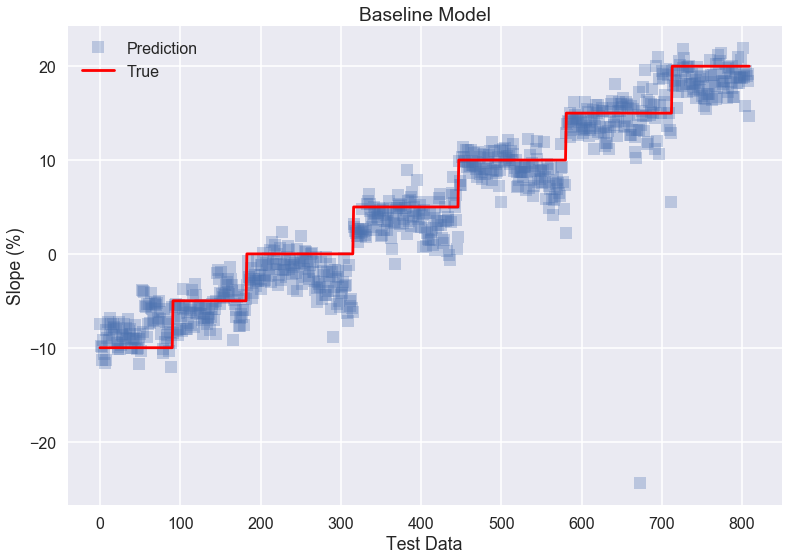

In [215]:
plt.plot(np.arange(len(y_test)), linear.predict(X_test), 's', alpha = 0.3, label = 'Prediction')
plt.plot(np.arange(len(y_test)), y_test_multi, 'r-', label = 'True')

plt.xlabel("Test Data")
plt.ylabel("Slope (%)")
plt.legend()
plt.title("Baseline Model")

### 2) Lasso (Leave One Subject Out CV)

In [125]:
paramlist = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100])

est_list = [];
for p in paramlist:
    lasso = Lasso(alpha= p)
    est_list.append(lasso)

best_p, best_score, best_est_lasso = custom_cv(est_list, X_train_std, y_train_multi, paramlist, subnum_train)
best_p

print("Best parameter:",best_p)

print('CV score is %.3f' %best_score)
score_lasso_cv_train = best_est_lasso.score(X_train_std, y_train_multi)
print('Score on train set is %.3f' %score_lasso_cv_train)

score_lasso_cv_test = best_est_lasso.score(X_test_std, y_test_multi)
print('Score on test set is %.3f' %score_lasso_cv_test)

/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best parameter: 0.0001
CV score is 1.000
Score on train set is 0.987
Score on test set is 0.947


In [138]:
print("number of predictor:", np.sum(best_est_lasso.coef_ != 0))
print("Classfication converted accuracy on Test set: %0.3f" %regression_to_classification(y_test_multi, best_est_lasso.predict(X_test_std))[1])

number of predictor: 1799
Classfication converted accuracy on Test set: 0.779


In [137]:
start_time = time.time()
best_est_lasso.predict(X_test_std.iloc[0,:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0011017322540283203 seconds ---


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### 3) Ridge (Leave One Subject Out CV)

In [127]:
paramlist = np.array([ 0.0001, 0.001, 0.01, 0.1, 1, 10, 100])

est_list = [];
for p in paramlist:
    ridge = Ridge(alpha= p)
    est_list.append(ridge)

best_p, best_score, best_est_ridge = custom_cv(est_list, X_train_std, y_train_multi, paramlist, subnum_train)


print("Best parameter:",best_p)

print('CV score is %.3f' %best_score)
score_ridge_cv_train = best_est_ridge.score(X_train_std, y_train_multi)
print('Score on train set is %.3f' %score_ridge_cv_train)

score_ridge_cv_test = best_est_ridge.score(X_test_std, y_test_multi)
print('Score on test set is %.3f' %score_ridge_cv_test)

Best parameter: 0.0001
CV score is 1.000
Score on train set is 0.987
Score on test set is 0.946


In [139]:
print("number of predictor:", np.sum(best_est_ridge.coef_ != 0))
print("Classfication converted accuracy on Test set: %0.3f" %regression_to_classification(y_test_multi, best_est_ridge.predict(X_test_std))[1])

number of predictor: 1928
Classfication converted accuracy on Test set: 0.772


In [136]:
start_time = time.time()
best_est_ridge.predict(X_test_std.iloc[0,:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0009348392486572266 seconds ---


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


### 4) Linear Regression (PCA Components: 90% explained variance)

In [141]:
# find number of components to explain 90% of variance

n = 200
pca = PCA(n_components=n)
pca.fit(X_train_std)
# if np.sum(pca.explained_variance_ratio_) > 0.7:
#     ninetypercent = True;
for i in range(n):
    if np.sum(pca.explained_variance_ratio_[:i]) > 0.90:
        break

ncomp = i
ncomp

pca = PCA(n_components=ncomp)
pca.fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)



linear_pca = LinearRegression()
linear_pca.fit(X_train_pca, y_train_multi)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [142]:

print('Score on train set is %.3f' %linear_pca.score(X_train_pca, y_train_multi))

print('Score on test set is %.3f' %linear_pca.score(X_test_pca, y_test_multi))

print("Classfication converted accuracy on Test set: %0.3f" %regression_to_classification(y_test_multi, linear_pca.predict(X_test_pca))[1])

Score on train set is 0.950
Score on test set is 0.947
Classfication converted accuracy on Test set: 0.754


In [143]:
print("number of predictor:", ncomp)

number of predictor: 61


In [144]:
start_time = time.time()

linear_pca.predict(X_test_pca[0,:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0004489421844482422 seconds ---


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


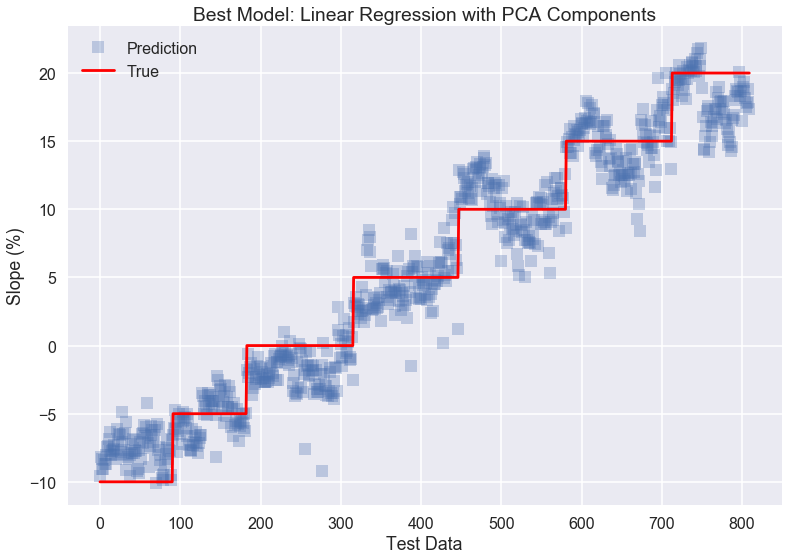

In [216]:
plt.plot(np.arange(len(y_test)), linear_pca.predict(X_test_pca), 's', alpha = 0.3, label = 'Prediction')
plt.plot(np.arange(len(y_test)), y_test_multi, 'r-', label = 'True')

plt.xlabel("Test Data")
plt.ylabel("Slope (%)")
plt.legend()
plt.title("Best Model: Linear Regression with PCA Components")

### 5) Lasso (2nd order predictors of PCA Components: 90% explained variance)

In [145]:
### Higher Order Polynomial

poly_2 = PolynomialFeatures(degree = 2, include_bias = False)
X_train_pca_poly_2 = poly_2.fit_transform(X_train_pca)
X_test_pca_poly_2 = poly_2.fit_transform(X_test_pca)


lambdas = [.001,.01, 0.1, 1, 10, 100, 1000]
# lambdas = [3,7, 10, 20, 30 , 50, 80]

lasso_pca_poly_2 = LassoCV(cv=5, alphas=lambdas, fit_intercept=True, normalize=False)
lasso_pca_poly_2.fit(X_train_pca_poly_2, y_train_multi)



/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100, 1000], copy_X=True, cv=5,
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [147]:
print('Score on train set is %.3f'  %lasso_pca_poly_2.score(X_train_pca_poly_2, y_train_multi))
print('Score on test set is %.3f' %lasso_pca_poly_2.score(X_test_pca_poly_2, y_test_multi))
print("Classfication converted accuracy on Test set: %0.3f" %regression_to_classification(y_test_multi, lasso_pca_poly_2.predict(X_test_pca_poly_2))[1])
      
print("number of predictor:", np.sum(lasso_pca_poly_2.coef_ != 0))

Score on train set is 0.996
Score on test set is 0.937
Classfication converted accuracy on Test set: 0.743
number of predictor: 1608


In [148]:
start_time = time.time()

linear_pca.predict(X_test_pca[0,:])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0005300045013427734 seconds ---


/Users/personalmac/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


## 3.1 Regression (Individual Model)

## Linear Regression (PCA Components: 90% explained variance)

In [158]:
X_train_list_m, y_train_multi_list_m, X_test_list_m, y_test_multi_list_m= subject_set(X_train_pca, y_train_multi, subnum_train)


linear_pca_ind_list = [None] * len(X_train_list_m)
score_linear_pca_train_list = [None] * len(X_train_list_m)
score_linear_pca_test_list = [None] * len(X_train_list_m)

for i in range(len(X_train_list_m)):

    linear_pca_ind = LinearRegression()
    linear_pca_ind.fit(X_train_list_m[i], y_train_multi_list_m[i])

    linear_pca_ind_list[i] = linear_pca_ind
    
    score_linear_pca_train_list[i] = linear_pca_ind.score(X_train_list_m[i], y_train_multi_list_m[i])
    score_linear_pca_test_list[i]  = linear_pca_ind.score(X_test_list_m[i], y_test_multi_list_m[i])



In [159]:
print('Average score on train set is %.3f'  %np.average(score_linear_pca_train_list))
print('Average score on test set is %.3f' %np.average(score_linear_pca_test_list))

print("number of predictor:", X_train_list_m[0].shape[1])

Average score on train set is 0.983
Average score on test set is 0.978
number of predictor: 61


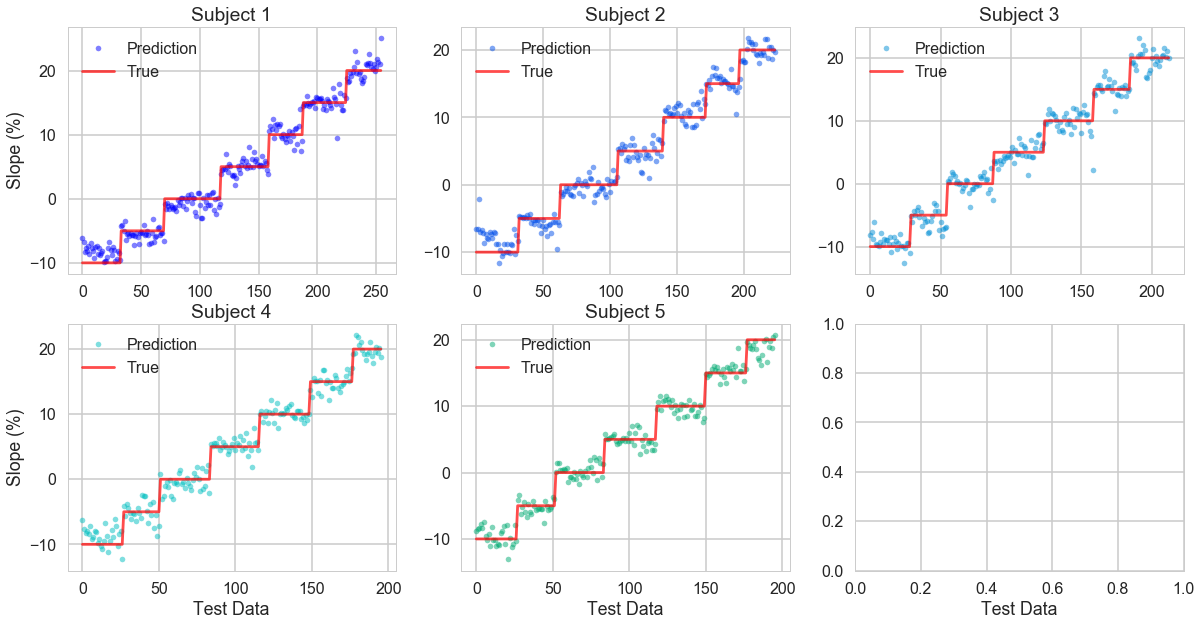

In [265]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
axes = axes.flatten()

for i in range(len(X_train_list_m)):
    axes[i].plot(linear_pca_ind_list[i].predict(X_test_list_m[i]), '.', color= colors[i].get_rgb(), alpha = 0.5, label = 'Prediction')
    axes[i].plot(y_test_multi_list_m[i].values, 'r-', alpha = 0.7, label = 'True')
    axes[i].set_title('Subject '+str(i+1))
    axes[i].legend()



axes[3].set_xlabel("Test Data")
axes[4].set_xlabel("Test Data")
axes[5].set_xlabel("Test Data")

axes[0].set_ylabel("Slope (%)")
axes[3].set_ylabel("Slope (%)")


plt.show()